<a href="https://colab.research.google.com/github/IT24102088/Plant-Disease-Detection-System-final-PG-NO-147/blob/main/aimlSVMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import clear_output
import os
from skimage.color import rgb2gray
import joblib
from tqdm import tqdm

In [ ]:
!unzip /content/drive/MyDrive/datasets/new-plant-diseases-dataset.zip
clear_output();

In [ ]:
DATASET_PATH = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VALID_PATH = os.path.join(DATASET_PATH, 'valid')

In [ ]:
# Preprocessing method

def extract_advanced_features(img_path, img_size=(64, 64)):
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0

    features = []

    # Color features (15 features)
    for channel in range(3):
        channel_data = img_array[:, :, channel]
        features.extend([
            np.mean(channel_data),      # Average color
            np.std(channel_data),       # Contrast
            np.median(channel_data),    # Middle value
            np.min(channel_data),       # Darkest
            np.max(channel_data)        # Brightest
        ])

    # Texture features (4 features)
    gray = rgb2gray(img_array)
    features.extend([
        np.mean(np.abs(np.diff(gray, axis=0))),  # Vertical edges
        np.mean(np.abs(np.diff(gray, axis=1))),  # Horizontal edges
        np.std(gray),                            # Overall texture
        np.mean(gray > 0.5)                      # Bright areas
    ])

    # Spatial color features (6 features)
    h, w = img_size
    top_mean = np.mean(img_array[:h//2], axis=(0,1))
    bottom_mean = np.mean(img_array[h//2:], axis=(0,1))
    features.extend(np.abs(top_mean - bottom_mean))

    return np.array(features)  # 25 total features



In [ ]:
# Preprocessing

def process_dataset(data_path, max_samples_per_class=200):
    all_features = []
    all_labels = []
    all_class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

    class_names  = [class_name for class_name in all_class_names if 'healthy' not in class_name.lower()]

    for class_id, class_name in enumerate(tqdm(class_names, desc="Classes")):
        class_path = os.path.join(data_path, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if max_samples_per_class:
            image_files = image_files[:max_samples_per_class]

        for img_file in tqdm(image_files, desc=f"{class_name}", leave=False):
            img_path = os.path.join(class_path, img_file)
            try:
                features = extract_advanced_features(img_path)
                all_features.append(features)
                all_labels.append(class_id)
            except Exception as e:
                continue

    X = np.array(all_features)
    y = np.array(all_labels)

    print(f"Processed {X.shape[0]} images with {X.shape[1]} features each")
    return X, y, class_names

In [ ]:
X_train, y_train, class_names = process_dataset(TRAIN_PATH, max_samples_per_class=150)

X_val, y_val, _ = process_dataset(VALID_PATH, max_samples_per_class=50)

print(f"\nTraining: {X_train.shape}, Validation: {X_val.shape}")

Classes:  15%|█▌        | 4/26 [00:02<00:12,  1.70it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:   0%|          | 0/150 [00:00<?, ?it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  18%|█▊        | 27/150 [00:00<00:00, 267.51it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  36%|███▌      | 54/150 [00:00<00:00, 258.56it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  53%|█████▎    | 80/150 [00:00<00:00, 256.38it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  71%|███████   | 106/150 [00:00<00:00, 257.26it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  88%|████████▊ | 132/150 [00:00<00:00, 245.70it/s]
Classes: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


Processed 3900 images with 22 features each


Classes:  15%|█▌        | 4/26 [00:00<00:04,  5.18it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:   0%|          | 0/50 [00:00<?, ?it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  56%|█████▌    | 28/50 [00:00<00:00, 276.94it/s]
Classes: 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]

Processed 1300 images with 22 features each

Training: (3900, 22), Validation: (1300, 22)


In [ ]:
# train model
svm = LinearSVC(C=5, class_weight='balanced',random_state=42, max_iter=1000)
svm.fit(X_train, y_train)

LinearSVC(C=5, class_weight='balanced', random_state=42)

In [ ]:
# evaluate model
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

In [ ]:
print(f"\nValidation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names, digits=3))



Validation Accuracy: 0.5523

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.541     0.660     0.595        50
                                 Apple___Black_rot      0.442     0.680     0.535        50
                          Apple___Cedar_apple_rust      0.617     0.580     0.598        50
          Cherry_(including_sour)___Powdery_mildew      0.444     0.320     0.372        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.667     0.360     0.468        50
                       Corn_(maize)___Common_rust_      0.750     0.900     0.818        50
               Corn_(maize)___Northern_Leaf_Blight      0.667     0.880     0.759        50
                                 Grape___Black_rot      0.467     0.420     0.442        50
                      Grape___Esca_(Black_Measles)      0.473     0.700     0.565        50
        Grape___Leaf_bligh

In [ ]:
# Check training vs validation accuracy to detect overfitting
train_pred = svm.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
val_accuracy = accuracy_score(y_val, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Gap (Overfitting indicator): {train_accuracy - val_accuracy:.4f}")

if train_accuracy - val_accuracy > 0.1:
    print("\nhigh overfitting")
elif train_accuracy - val_accuracy > 0.05:
    print("\nmoderately high overfitting")
else:
    print("\nwell generalized")

Training Accuracy: 0.5567
Validation Accuracy: 0.5523
Gap (Overfitting indicator): 0.0044

well generalized


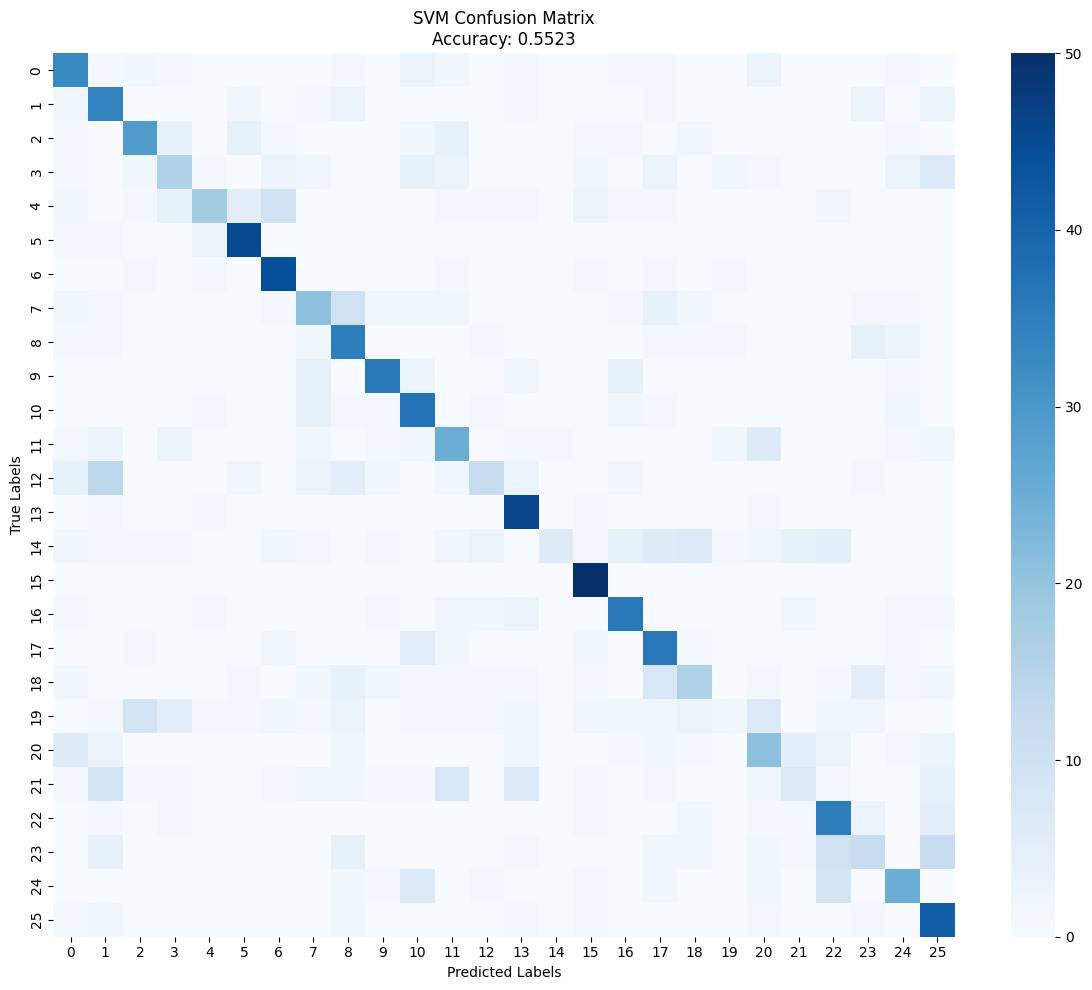

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title(f'SVM Confusion Matrix\nAccuracy: {accuracy:.4f}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import joblib

joblib.dump(svm, '/content/drive/MyDrive/svm_model.joblib')

['/content/drive/MyDrive/svm_model.joblib']

In [ ]:
# loaded_model = joblib.load('/content/drive/MyDrive/svm_model.joblib')